## PRACTICE 1: PyTorch FashionMNIST Classification

**TÊN : Nguyễn Văn Thương**

**MSSV : 077205005581**

<h1 align="center"> Implement </h1>

# LIRARY

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1. LOAD FASHIONMNIST DATASET 

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


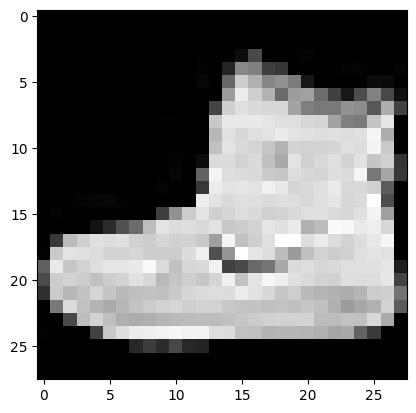

Label: 9


In [3]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# 2. APPLY TRANSFORMS 

In [4]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
from torchvision.transforms import ToTensor, Lambda
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

In [6]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# 3. BUILD A NEURAL NETWORK

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [8]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# 4. CREATE TRAINING LOOP 

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()  # đặt model ở chế độ training
    total_loss = 0
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        # Chuyển dữ liệu sang GPU (nếu có)
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()   # reset gradient trước mỗi batch (đặt lên đầu để rõ ràng)
        loss.backward()
        optimizer.step()

        # In loss mỗi 100 batch
        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / len(dataloader)
    print(f"Average training loss: {avg_loss:.6f}")
    return avg_loss

In [11]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()  # đặt model ở chế độ đánh giá (tắt dropout, batchnorm update)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():  # không tính gradient trong giai đoạn test
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error:\n Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {test_loss:.6f}\n")
    return accuracy, test_loss

# 5. EVALUATE MODEL ACCURACY

In [12]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [13]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298709  [    0/60000]


loss: 2.288947  [ 6400/60000]
loss: 2.268164  [12800/60000]
loss: 2.266105  [19200/60000]
loss: 2.245189  [25600/60000]
loss: 2.216801  [32000/60000]
loss: 2.231431  [38400/60000]
loss: 2.191702  [44800/60000]
loss: 2.188871  [51200/60000]
loss: 2.169425  [57600/60000]
Average training loss: 2.230322
Test Error:
 Accuracy: 41.1%, Avg loss: 2.153249

Epoch 2
-------------------------------
loss: 2.167915  [    0/60000]
loss: 2.158671  [ 6400/60000]
loss: 2.100725  [12800/60000]
loss: 2.116988  [19200/60000]
loss: 2.067656  [25600/60000]
loss: 2.011993  [32000/60000]
loss: 2.053871  [38400/60000]
loss: 1.968247  [44800/60000]
loss: 1.974979  [51200/60000]
loss: 1.924844  [57600/60000]
Average training loss: 2.039318
Test Error:
 Accuracy: 49.8%, Avg loss: 1.902279

Epoch 3
-------------------------------
loss: 1.944101  [    0/60000]
loss: 1.914540  [ 6400/60000]
loss: 1.795821  [12800/60000]
loss: 1.833907  [19200/60000]
loss: 1.728908  [25600/60000]
loss: 1.686509  [32000/60000]
loss: 

Epoch 1
-------------------------------
loss: 0.801459  [    0/60000]
loss: 0.878471  [ 6400/60000]
loss: 0.642132  [12800/60000]
loss: 0.838599  [19200/60000]
loss: 0.757688  [25600/60000]
loss: 0.739245  [32000/60000]
loss: 0.822916  [38400/60000]
loss: 0.790284  [44800/60000]
loss: 0.795155  [51200/60000]
loss: 0.748013  [57600/60000]
Average training loss: 0.759240
loss: 0.764014  [    0/60000]
loss: 0.849180  [ 6400/60000]
loss: 0.609712  [12800/60000]
loss: 0.814414  [19200/60000]
loss: 0.737081  [25600/60000]
loss: 0.713950  [32000/60000]
loss: 0.797860  [38400/60000]
loss: 0.773367  [44800/60000]
loss: 0.772631  [51200/60000]
loss: 0.726324  [57600/60000]
Average training loss: 0.734720
Test Error:
 Accuracy: 73.0%, Avg loss: 0.739261

Epoch 2
-------------------------------
loss: 0.731145  [    0/60000]
loss: 0.822951  [ 6400/60000]
loss: 0.582060  [12800/60000]
loss: 0.794014  [19200/60000]
loss: 0.719244  [25600/60000]
loss: 0.693105  [32000/60000]
loss: 0.775284  [38400/600

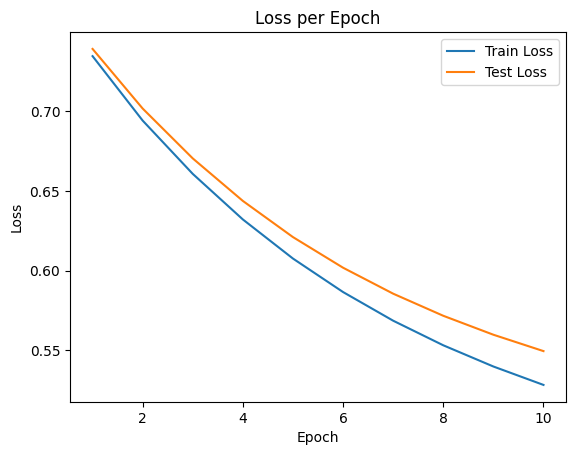

In [16]:
# vizualize the loss
import matplotlib.pyplot as plt

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    # Sau mỗi epoch, thêm loss vào list
    avg_train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    train_losses.append(avg_train_loss)
    accuracy, avg_test_loss = test_loop(test_dataloader, model, loss_fn, device)
    test_losses.append(avg_test_loss)

# Vẽ biểu đồ loss
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

# 8. SAVE AND LOAD THE MODEL

In [17]:
import torch
import torchvision.models as models

torch.save(model.state_dict(), "model.pth")
print("Model weights saved successfully!")

Model weights saved successfully!


In [18]:
torch.save(model.state_dict(), "model.pth")
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()

C:\Users\nguye\AppData\Local\Temp\ipykernel_17024\515601284.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

<h1 align="center">Task </h1>

# 1. Experiment with network/hyperparameters

In [19]:
# Thử thay đổi số lớp hoặc số node
class NeuralNetworkV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),  # giảm số node xuống 256
            nn.ReLU(),
            nn.Linear(256, 128),    # thêm một lớp 128 node
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Đổi optimizer sang Adam, thay đổi learning rate
model = NeuralNetworkV2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [20]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")


Epoch 1
-------------------------------
loss: 2.304921  [    0/60000]
loss: 1.402114  [ 6400/60000]
loss: 0.810630  [12800/60000]
loss: 0.879635  [19200/60000]
loss: 0.648180  [25600/60000]
loss: 0.599146  [32000/60000]
loss: 0.598455  [38400/60000]
loss: 0.666065  [44800/60000]
loss: 0.621772  [51200/60000]
loss: 0.547039  [57600/60000]
Average training loss: 0.816691
Test Error:
 Accuracy: 80.5%, Avg loss: 0.553192

Epoch 2
-------------------------------
loss: 0.477896  [    0/60000]
loss: 0.572441  [ 6400/60000]
loss: 0.380136  [12800/60000]
loss: 0.598684  [19200/60000]
loss: 0.491459  [25600/60000]
loss: 0.460308  [32000/60000]
loss: 0.444404  [38400/60000]
loss: 0.639332  [44800/60000]
loss: 0.582475  [51200/60000]
loss: 0.434705  [57600/60000]
Average training loss: 0.486212
Test Error:
 Accuracy: 83.1%, Avg loss: 0.479609

Epoch 3
-------------------------------
loss: 0.359227  [    0/60000]
loss: 0.476305  [ 6400/60000]
loss: 0.321952  [12800/60000]
loss: 0.522538  [19200/600

# 2. Visualize loss

Epoch 1
-------------------------------
loss: 0.248586  [    0/60000]
loss: 0.371664  [ 6400/60000]
loss: 0.261072  [12800/60000]
loss: 0.450969  [19200/60000]
loss: 0.319361  [25600/60000]
loss: 0.378541  [32000/60000]
loss: 0.343827  [38400/60000]
loss: 0.545432  [44800/60000]
loss: 0.479180  [51200/60000]
loss: 0.373426  [57600/60000]
Average training loss: 0.370351
loss: 0.232745  [    0/60000]
loss: 0.352578  [ 6400/60000]
loss: 0.247438  [12800/60000]
loss: 0.435247  [19200/60000]
loss: 0.302414  [25600/60000]
loss: 0.367542  [32000/60000]
loss: 0.333056  [38400/60000]
loss: 0.531240  [44800/60000]
loss: 0.464454  [51200/60000]
loss: 0.369494  [57600/60000]
Average training loss: 0.357957
Test Error:
 Accuracy: 85.9%, Avg loss: 0.391689

Epoch 2
-------------------------------
loss: 0.222065  [    0/60000]
loss: 0.337661  [ 6400/60000]
loss: 0.237506  [12800/60000]
loss: 0.422750  [19200/60000]
loss: 0.290302  [25600/60000]
loss: 0.356025  [32000/60000]
loss: 0.323644  [38400/600

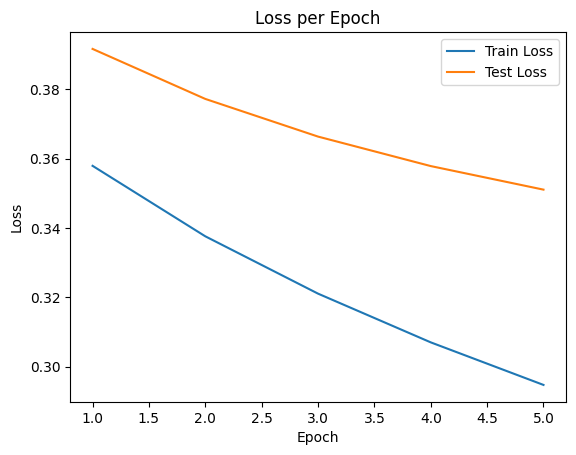

In [21]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    # Sau mỗi epoch, thêm loss vào list
    avg_train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    train_losses.append(avg_train_loss)
    accuracy, avg_test_loss = test_loop(test_dataloader, model, loss_fn, device)
    test_losses.append(avg_test_loss)

# Vẽ biểu đồ loss
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

# 3. Display predicted vs actual images

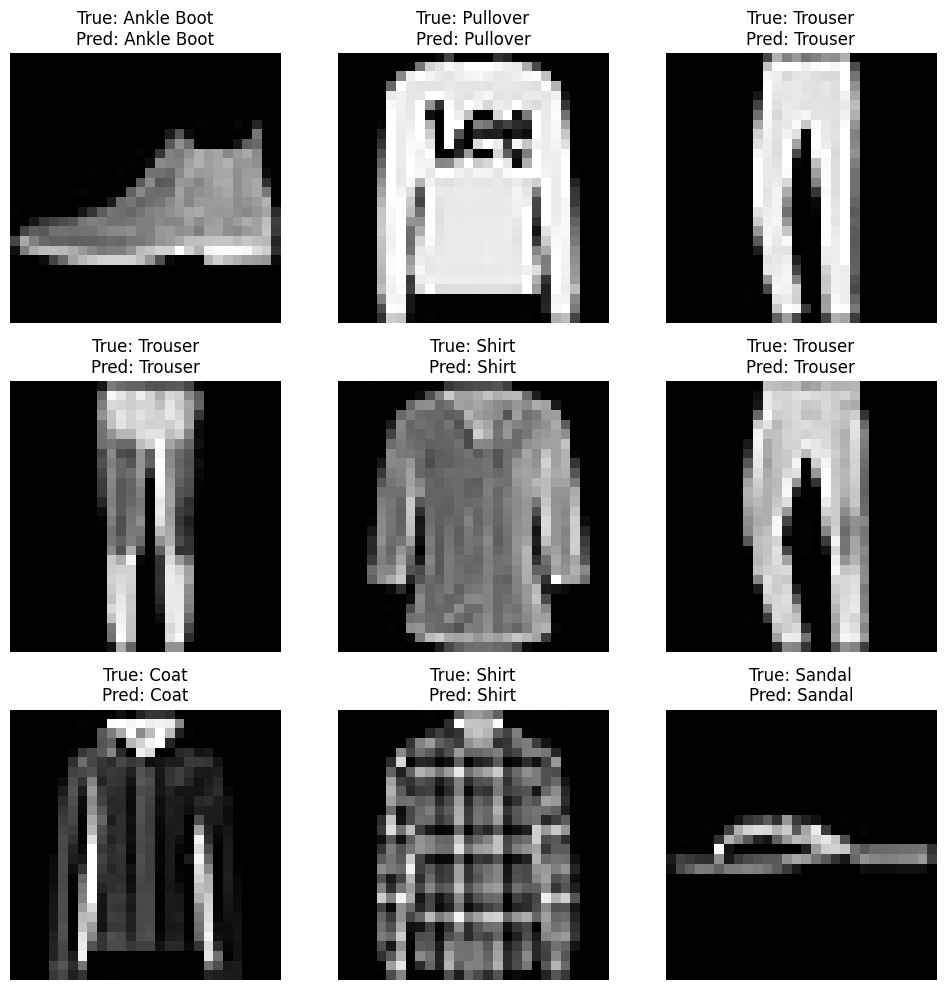

In [22]:
classes = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Lấy một batch từ test_dataloader
test_features, test_labels = next(iter(test_dataloader))
test_features, test_labels = test_features.to(device), test_labels.to(device)
model.eval()
with torch.no_grad():
    preds = model(test_features).argmax(1)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_features[i].cpu().squeeze(), cmap='gray')
    plt.title(f"True: {classes[test_labels[i].item()]}\nPred: {classes[preds[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()